# Emergency Room Process Analysis

Short description of what this notebook is about

## 1. Import Libraries

In [19]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
import datetime

RANDOM_SEED = 42
random.seed(RANDOM_SEED)


## 2. Define the Patient Class
Defines a Patient class to represent each patient in the simulation, tracking key attributes such as arrival time, wait times for triage and treatment, and total time in the system. 

In [20]:
import datetime  # for handling timestamps

class Patient:
    def __init__(self, patient_id, env):
        self.patient_id = patient_id
        self.env = env
        self.arrival_time = env.now
        self.wait_for_triage_check = 0
        self.wait_for_triage = 0
        self.wait_for_treatment = 0
        self.time_in_system = 0
        self.triage_check_start_time = None
        self.triage_start_time = None
        self.treatment_start_time = None
        self.departure_time = None

    def record_triage_check_start(self):
        self.triage_check_start_time = self.env.now

    def record_triage_start(self):
        self.triage_start_time = self.env.now

    def record_treatment_start(self):
        self.treatment_start_time = self.env.now

    def record_departure(self):
        self.departure_time = self.env.now
        self.time_in_system = self.departure_time - self.arrival_time

    def format_time(self, sim_time):
        """Convert simulation time to a human-readable string in the format 'HH:MM'."""
        hours, remainder = divmod(sim_time, 60)
        minutes = int(remainder)
        return f'{int(hours):02d}:{minutes:02d}'

    def get_arrival_timestamp(self):
        return self.format_time(self.arrival_time)

    def get_triage_check_start_timestamp(self):
        if self.triage_check_start_time is not None:
            return self.format_time(self.triage_check_start_time)
        else:
            return None

    def get_triage_start_timestamp(self):
        if self.triage_start_time is not None:
            return self.format_time(self.triage_start_time)
        else:
            return None

    def get_treatment_start_timestamp(self):
        if self.treatment_start_time is not None:
            return self.format_time(self.treatment_start_time)
        else:
            return None

    def get_departure_timestamp(self):
        if self.departure_time is not None:
            return self.format_time(self.departure_time)
        else:
            return None


## 3. Define the ER Processes
Define functions simulate patient arrival, triage, and treatment processes using SimPy's event-based simulation capabilities. 

The specific ranges determine the variability in time taken for triage check, triage process and  doctortreatment, reflecting real-world variability.

In [21]:
def patient_arrival(env, patient_id, er):
    patient = Patient(patient_id, env)
    
    # Increment overall occupancy
    er.increment_occupancy()
    
    # Update triage stage occupancy
    er.update_stage_occupancy('triage', 1)

    # Record arrival time
    print(f"Patient {patient.patient_id} arrived at {patient.get_arrival_timestamp()}")

    # Triage Nurse Check
    with er.triage_nurse.request() as request:
        yield request
        patient.wait_for_triage_check = env.now - patient.arrival_time
        patient.record_triage_check_start()
        yield env.process(triage_nurse_check(patient))

    # Triage Process
    with er.triage_nurse.request() as request:
        yield request
        patient.wait_for_triage = env.now - (patient.arrival_time + patient.wait_for_triage_check)
        patient.record_triage_start()
        yield env.process(triage(patient))
        er.update_stage_occupancy('triage', 1)  # Update triage occupancy when starting triage


    # Treatment Process
    with er.doctor.request() as request:
        yield request
        patient.wait_for_treatment = env.now - (patient.arrival_time + patient.wait_for_triage_check + patient.wait_for_triage)
        patient.record_treatment_start()
        er.update_stage_occupancy('triage', -1)  # Update triage occupancy when leaving triage
        er.update_stage_occupancy('treatment', 1)  # Update treatment occupancy when starting treatment
        yield env.process(treatment(patient))  
        er.update_stage_occupancy('treatment', -1)  # Update treatment occupancy when ending treatment

    # Discharge
    with er.triage_nurse.request() as request:
        yield request
        yield env.process(discharge(patient))

    patient.record_departure()
    er.patient_log.append(patient)
    
    # Print departure time
    print(f"Patient {patient.patient_id} departed at {patient.get_departure_timestamp()}")

def patient_departure(patient, er):
    # Decrement overall occupancy
    er.decrement_occupancy()

    # Update triage stage occupancy
    er.update_stage_occupancy('triage', -1)
def triage_nurse_check(patient):
    yield patient.env.timeout(random.normalvariate(10, 2.5))


# Assuming an average arrival rate of 20 patients per hour
average_arrival_rate_per_hour = 20
average_arrival_rate_per_minute = average_arrival_rate_per_hour / 60

# Set the parameter for random.expovariate
arrival_rate_parameter = 1.0 / average_arrival_rate_per_minute


def triage(patient):
    yield patient.env.timeout(random.expovariate(arrival_rate_parameter))

def treatment(patient):
    yield patient.env.timeout(random.normalvariate(120, 40))

def discharge(patient):
    delay = max(0, random.normalvariate(5, 2))
    yield patient.env.timeout(delay)



## 4. Define the ER Environment
Defines an EmergencyRoom class to set up the simulation environment with resources (triage_nurse and doctor), and a patient_log to track patient data. The capacity is also set up here. 

In [22]:
class EmergencyRoom:
    def __init__(self, env, num_triage_nurses, num_doctors):
        self.env = env
        self.triage_nurse = simpy.Resource(env, capacity=num_triage_nurses)
        self.doctor = simpy.Resource(env, capacity=num_doctors)
        self.patient_log = []
        self.current_patients = 0
        self.occupancy_log = []

        # Initialize dictionaries for stage-wise occupancy
        self.triage_occupancy = {'time': [], 'occupancy': []}
        self.treatment_occupancy = {'time': [], 'occupancy': []}
        self.discharge_occupancy = {'time': [], 'occupancy': []}

    def increment_occupancy(self):
        self.current_patients += 1
        self.occupancy_log.append((self.env.now, self.current_patients))

    def decrement_occupancy(self):
        self.current_patients -= 1
        self.occupancy_log.append((self.env.now, self.current_patients))

        # Function to update stage-wise occupancy
    def update_stage_occupancy(self, stage_name, change):
        stage_dict = getattr(self, f"{stage_name}_occupancy")
        stage_dict['time'].append(self.env.now)
        stage_dict['occupancy'].append(stage_dict['occupancy'][-1] + change if stage_dict['occupancy'] else change)


def run_er(env, er):
    patient_id = 0
    while True:
        yield env.timeout(random.expovariate(1/5))
        env.process(patient_arrival(env, patient_id, er))
        patient_id += 1

## 5. Run the Simulation
Initializes the simulation environment (env), creates an EmergencyRoom instance (er), starts the simulation process (run_er), and runs the simulation for 24 hours:

In [23]:
env = simpy.Environment()
er = EmergencyRoom(env, num_triage_nurses=4, num_doctors=20)
env.process(run_er(env, er))
env.run(until=1440)  # Run for 24 hours (1440 minutes)


Patient 0 arrived at 00:05
Patient 1 arrived at 00:05
Patient 2 arrived at 00:11
Patient 3 arrived at 00:12
Patient 4 arrived at 00:13
Patient 5 arrived at 00:14
Patient 6 arrived at 00:15
Patient 7 arrived at 00:20
Patient 8 arrived at 00:28
Patient 9 arrived at 00:29
Patient 10 arrived at 00:31
Patient 11 arrived at 00:36
Patient 12 arrived at 00:59
Patient 13 arrived at 01:00
Patient 14 arrived at 01:03
Patient 15 arrived at 01:03
Patient 16 arrived at 01:11
Patient 17 arrived at 01:14
Patient 18 arrived at 01:18
Patient 19 arrived at 01:29
Patient 20 arrived at 01:39
Patient 21 arrived at 01:41
Patient 22 arrived at 01:42
Patient 23 arrived at 01:46
Patient 24 arrived at 01:46
Patient 25 arrived at 01:58
Patient 9 departed at 02:04
Patient 26 arrived at 02:06
Patient 1 departed at 02:09
Patient 27 arrived at 02:12
Patient 11 departed at 02:16
Patient 28 arrived at 02:16
Patient 29 arrived at 02:19
Patient 8 departed at 02:20
Patient 5 departed at 02:29
Patient 30 arrived at 02:40
P

## 6. Analyze the Results
Collects simulation data into a pandas DataFrame (df), computes descriptive statistics, and visualizes results using histograms:

       patient_id  wait_for_triage_check  wait_for_triage  wait_for_treatment  \
count  211.000000             211.000000       211.000000          211.000000   
mean   105.080569               2.135024        12.633256          103.570183   
std     61.194290               3.846898         5.220515           70.875515   
min      0.000000               0.000000         4.451898            0.001971   
25%     52.500000               0.000000         8.811715           34.864232   
50%    105.000000               0.000000        11.339658          109.510026   
75%    157.500000               2.658297        14.897392          163.123154   
max    216.000000              20.352283        31.227124          235.436348   

       time_in_system  
count      211.000000  
mean       248.072027  
std         78.683851  
min         81.166404  
25%        184.305578  
50%        253.538139  
75%        315.334633  
max        426.880445  


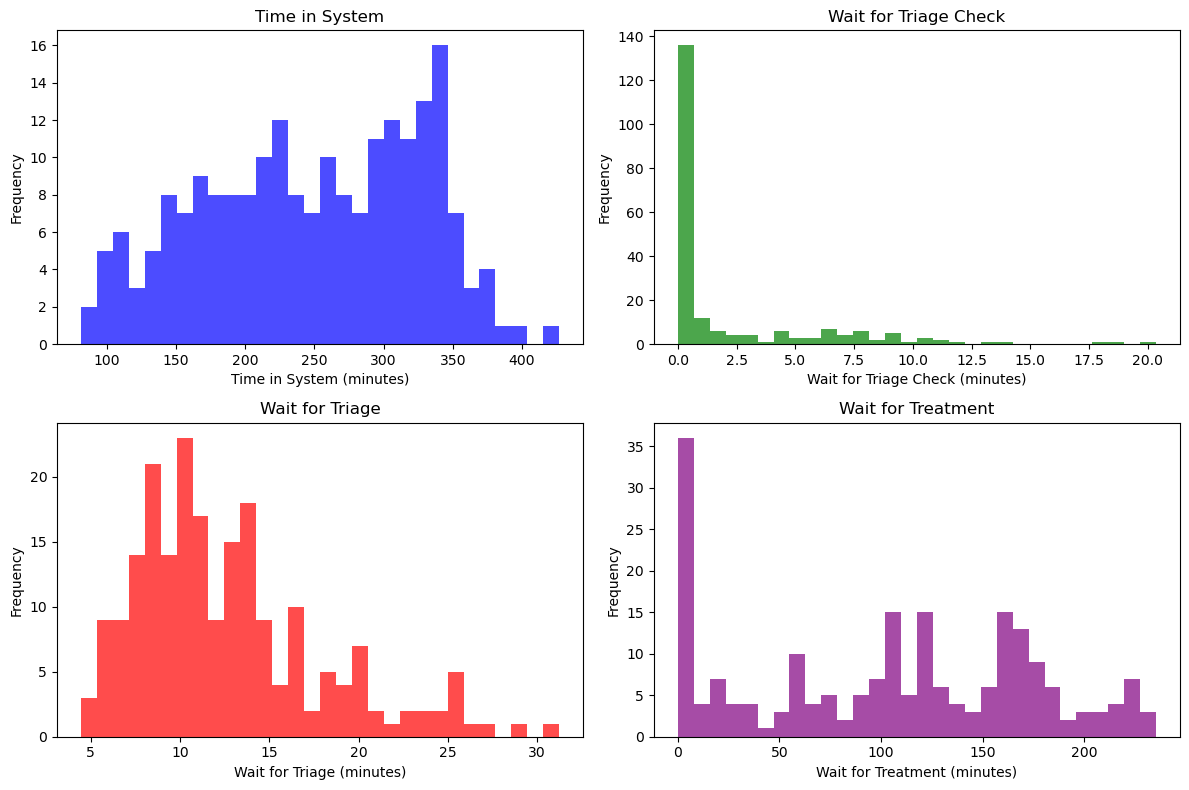

Average occupancy in Treatment stage: 19.406591081240645


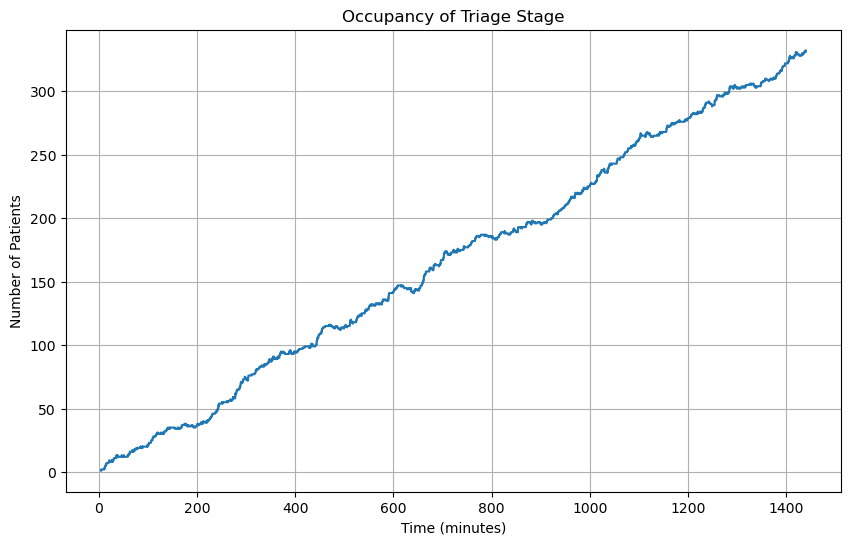

In [25]:
# Collect data
data = {
    "patient_id": [],
    "arrival_time": [],
    "triage_check_start_time": [],
    "triage_start_time": [],
    "treatment_start_time": [],
    "departure_time": [],
    "wait_for_triage_check": [],
    "wait_for_triage": [],
    "wait_for_treatment": [],
    "time_in_system": []
}

for patient in er.patient_log:
    data["patient_id"].append(patient.patient_id)
    data["arrival_time"].append(patient.get_arrival_timestamp())
    data["triage_check_start_time"].append(patient.get_triage_check_start_timestamp())
    data["triage_start_time"].append(patient.get_triage_start_timestamp())
    data["treatment_start_time"].append(patient.get_treatment_start_timestamp())
    data["departure_time"].append(patient.get_departure_timestamp())
    data["wait_for_triage_check"].append(patient.wait_for_triage_check)
    data["wait_for_triage"].append(patient.wait_for_triage)
    data["wait_for_treatment"].append(patient.wait_for_treatment)
    data["time_in_system"].append(patient.time_in_system)

df = pd.DataFrame(data)

# Export to CSV
df.to_csv('./output/er_patient_log.csv', index=False)

# Summary statistics
print(df.describe())

# Plot histograms
plt.figure(figsize=(12, 8))

# Plot histogram for Time in System
plt.subplot(2, 2, 1)
plt.hist(df["time_in_system"], bins=30, alpha=0.7, color='blue')
plt.xlabel('Time in System (minutes)')
plt.ylabel('Frequency')
plt.title('Time in System')

# Plot histogram for Wait for Triage Check
plt.subplot(2, 2, 2)
plt.hist(df["wait_for_triage_check"], bins=30, alpha=0.7, color='green')
plt.xlabel('Wait for Triage Check (minutes)')
plt.ylabel('Frequency')
plt.title('Wait for Triage Check')

# Plot histogram for Wait for Triage
plt.subplot(2, 2, 3)
plt.hist(df["wait_for_triage"], bins=30, alpha=0.7, color='red')
plt.xlabel('Wait for Triage (minutes)')
plt.ylabel('Frequency')
plt.title('Wait for Triage')

# Plot histogram for Wait for Treatment
plt.subplot(2, 2, 4)
plt.hist(df["wait_for_treatment"], bins=30, alpha=0.7, color='purple')
plt.xlabel('Wait for Treatment (minutes)')
plt.ylabel('Frequency')
plt.title('Wait for Treatment')

plt.tight_layout()
plt.show()

# Calculate time-weighted statistics for treatment occupancy
def calculate_time_weighted_stats(occupancy_data):
    total_time = max(occupancy_data['time']) - min(occupancy_data['time'])
    total_occupied_time = sum((occupancy_data['time'][i+1] - occupancy_data['time'][i]) * occupancy_data['occupancy'][i] for i in range(len(occupancy_data['time']) - 1))
    avg_occupancy = total_occupied_time / total_time if total_time > 0 else 0
    return avg_occupancy

# Example calculation for treatment stage
treatment_avg_occupancy = calculate_time_weighted_stats(er.treatment_occupancy)
print(f"Average occupancy in Treatment stage: {treatment_avg_occupancy}")

# Example visualization for triage stage occupancy
plt.figure(figsize=(10, 6))
plt.step(er.triage_occupancy['time'], er.triage_occupancy['occupancy'], where='post')
plt.xlabel('Time (minutes)')
plt.ylabel('Number of Patients')
plt.title('Occupancy of Triage Stage')
plt.grid(True)
plt.show()